# » `Dependencias`:

In [ ]:
# !pip install plotly
# !pip install sqlalchemy
# !pip install numpy
# !pip install matplotlib

In [4]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import re
# import cufflinks as cf
# from IPython.display import display, HTML

# cf.set_config_file

## 1. Conección → SIM(172.27.0.124)

In [5]:
# spring.datasource.url = jdbc:sqlserver://172.27.250.27;databaseName=SIRIM
SERVER = '172.27.0.242' #'172.27.0.124'
#DRIVER = 'SQL Server Native Client 11.0'
DRIVER = 'ODBC Driver 17 for SQL Server'
DATABASE = 'SIM'
USERNAME = 'udesa' # userestadistica
PASSWORD = 'DESARROLLO2006' # $Us3R_3sT4d1sTic4$
DATABASE_CONNECTION = f'mssql://{USERNAME}:{PASSWORD}@{SERVER}/{DATABASE}?driver={DRIVER}'

engine = create_engine(DATABASE_CONNECTION)
connection = engine.connect()

## 2. Métodos genérico:

In [6]:
def get_query_sql(query):
  try:
    df = pd.read_sql(query, connection)
    return df
  except:
    print('¡Ocurrió un error!')

## 3. Visualización de datos: `INF-MAY2024`

### 3.1 Prefijo de número de trámite no corresponde a prefijo de trámite de dependencia.

In [4]:
QUERY_INFO_1 = '''
                  SELECT -- Prefijo igual
                     TOP 100000
                     [Número Tramite] = t.sNumeroTramite,
                     [Dependencia] = d.sNombre,
                     [Prefijo Trámite Dependencia] = d.sPrefijoTramite
                  FROM SimTramite t
                  JOIN SimTipoTramite tt ON t.nIdTipoTramite = tt.nIdTipoTramite
                  JOIN SimPersona p ON t.uIdPersona = p.uIdPersona
                  JOIN SimDependencia d ON t.sIdDependencia = d.sIdDependencia
                  WHERE
                     t.bCancelado = 0
                     AND (
                        t.sNumeroTramite LIKE '[a-zA-Z][a-zA-Z]%' -- Prefijo únicamente letras
                        AND d.sPrefijoTramite != 'SW'
                        AND d.sPrefijoTramite = LEFT(LTRIM(t.sNumeroTramite), 2)
                     )
                  UNION ALL
                  SELECT -- Prefijo distinto
                     TOP 10000
                     [Número Tramite] = t.sNumeroTramite,
                     [Dependencia] = d.sNombre,
                     [Prefijo Trámite Dependencia] = d.sPrefijoTramite
                  FROM SimTramite t
                  JOIN SimTipoTramite tt ON t.nIdTipoTramite = tt.nIdTipoTramite
                  JOIN SimPersona p ON t.uIdPersona = p.uIdPersona
                  JOIN SimDependencia d ON t.sIdDependencia = d.sIdDependencia
                  WHERE
                     t.bCancelado = 0
                     AND (
                        t.sNumeroTramite LIKE '[a-zA-Z][a-zA-Z]%' -- Prefijo únicamente letras
                        AND d.sPrefijoTramite NOT IN (LEFT(LTRIM(t.sNumeroTramite), 2), 'SW')
                     )

'''

df_1 = get_query_sql(QUERY_INFO_1)

In [ ]:
# ['Número Tramite', 'Dependencia', 'Prefijo Trámite Dependencia', 'sGrupo']
# Méthod's
def get_group_dep(serie):
   result = 'Prefix: [<>]'
   if (serie[['Número Tramite']].str[:2] == serie['Prefijo Trámite Dependencia']).all():
     result = 'Prefix: [=]'
   return result

# Set property
df_1['sGrupo'] = df_1.apply(get_group_dep, axis=1)

[Text(0, 0, 'Prefix: [<>]'), Text(1, 0, 'Prefix: [=]')]

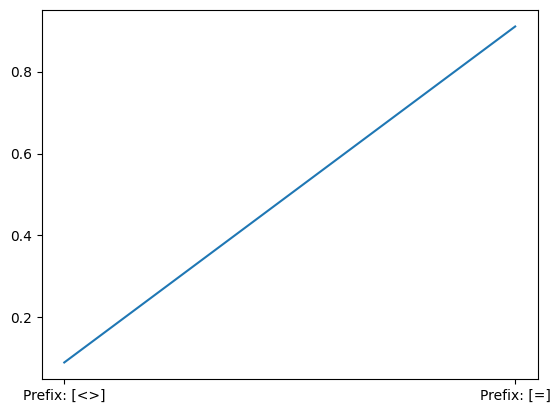

In [69]:
# plot:
#df_1.value_counts(['sGrupo'])

df_1_f = df_1.groupby(by=['sGrupo']).agg({ 'Número Tramite': [np.ma.count] }).droplevel(level=0, axis=1)
df_1_f['count'] = np.round(df_1_f['count'] / len(df_1), 2)

df_1_f_p = df_1_f.plot(legend=False, xlabel='')
df_1_f_p.set_xticks(ticks=[0, 1])
df_1_f_p.set_xticklabels(labels=['Prefix: [<>]', 'Prefix: [=]'])

### 3.2 Trámites de CCM, CPP y PTP con estato de trámite `PENDIENTE` en etapa que actualiza el estado a `APROBADO` con estado `FINALIZADO` ...

In [80]:
QUERY_INF_2 = '''
                  SELECT
                     t.sNumeroTramite,
                     tt.sSigla
                  FROM SimTramite t
                  JOIN SimTramiteInm ti ON t.sNumeroTramite = ti.sNumeroTramite
                  JOIN SimPersona p ON t.uIdPersona = p.uIdPersona
                  JOIN SimTipoTramite tt ON t.nIdTipoTramite = tt.nIdTipoTramite
                  WHERE
                     t.bCancelado = 0
                     AND ti.sEstadoActual = 'P'
                     AND t.nIdTipoTramite IN (58, 113, 126)-- 58 ↔ CCM; 113 ↔ CPP; 126 ↔ PTP
                     AND EXISTS ( -- Ultimas etapas
                        
                                    SELECT 1 FROM SimEtapaTramiteInm et
                                    WHERE
                                       et.sNumeroTramite = t.sNumeroTramite 
                                       AND et.bActivo = 1
                                       AND et.sEstado = 'F'
                                       AND et.nIdEtapa IN (17, 63, 80) -- 58, 113, 126
                                       -- AND et.nIdEtapa IN (24) -- 57
                              
                     )
                     AND NOT EXISTS ( -- Reconsideraciones o apelaciones

                           SELECT 
                              1
                           FROM SimEtapaTramiteInm eti
                           WHERE
                              eti.sNumeroTramite = t.sNumeroTramite 
                              AND eti.nIdEtapa IN (67, 68) -- 67 ↔ RECONSIDERACION.; 68 ↔ APELACION.
                              AND eti.sEstado = 'I'
                              AND eti.bActivo = 1
                              
                     )
'''

df_2 = get_query_sql(QUERY_INF_2)

<Axes: >

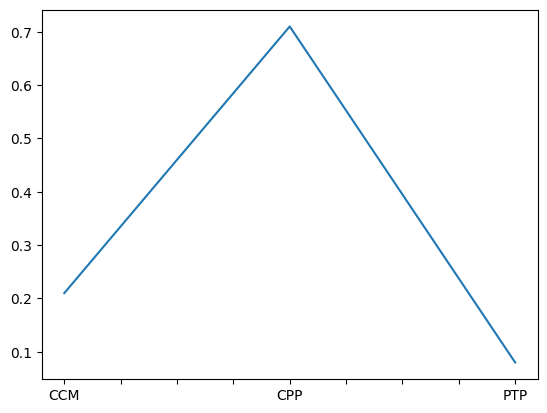

In [96]:
# ['sNumeroTramite', 'sSigla']
df_2_f = df_2.groupby(by=['sSigla']).agg({ 'sNumeroTramite': [np.ma.count] }).droplevel(level=0, axis=1)
df_2_f['count'] = np.round(df_2_f['count'] / len(df_2) , 2)
df_2_f.plot(legend=False, xlabel='')

### 3.3 Trámites de PRR, CCM, CPP y PTP con estado de trámite `APROBADO`, sin registro de etapa que actualiza el estado a `APROBADO` ...

In [90]:
QUERY_INF_3 = '''
                     SELECT
                        t.sNumeroTramite,
                        tt.sSigla
                     FROM SimTramite t
                     JOIN SimTramiteInm ti ON t.sNumeroTramite = ti.sNumeroTramite
                     JOIN SimTipoTramite tt ON t.nIdTipoTramite = tt.nIdTipoTramite
                     WHERE
                        t.bCancelado = 0
                        AND ti.sEstadoActual = 'A'
                        AND t.nIdTipoTramite IN (57, 58, 113, 126)-- 57 ↔ PRR; 58 ↔ CCM; 113 ↔ CPP; 126 ↔ PTP
                        AND YEAR(t.dFechaHora) >= (
                                                      SELECT et.nAño
                                                      FROM (
                                                         VALUES
                                                            (2021, 57), -- >=2021  = 22 ↔ CONFORMIDAD SUB-DIREC.INMGRA. 
                                                            (2022, 58), -- >=2022 = 17 ↔ ENTREGA DE CARNET EXTRANJERIA
                                                            (2021, 113), -- >=2021 = 63 ↔ ENTREGA DE CARNÉ P.T.P.
                                                            (2023, 126) -- >=2023 = 80 ↔ ENTREGA DE CARNÉ C.P.P.
                                                      ) et([nAño], [nIdTipoTramite])
                                                      WHERE
                                                         et.nIdTipoTramite = t.nIdTipoTramite
                        )
                        AND NOT EXISTS ( -- Etapas que aprueban el trámite ...
                           
                                       SELECT 1 FROM SimEtapaTramiteInm et
                                       WHERE
                                          et.sNumeroTramite = t.sNumeroTramite 
                                          AND et.bActivo = 1
                                          -- AND et.sEstado = 'F'
                                          AND (
                                             et.nIdEtapa = (
                                                                  SELECT et.nIdEtapa
                                                                  FROM (
                                                                     VALUES
                                                                        (57, 22), -- 57  = 22 ↔ CONFORMIDAD SUB-DIREC.INMGRA. 
                                                                        (58, 17), -- 58  = 17 ↔ ENTREGA DE CARNET EXTRANJERIA
                                                                        (113, 63), -- 113 = 63 ↔ ENTREGA DE CARNÉ P.T.P.
                                                                        (126, 80) -- 126 = 80 ↔ ENTREGA DE CARNÉ C.P.P.
                                                                  ) et([nIdTipoTramite], [nIdEtapa])
                                                                  WHERE
                                                                     et.nIdTipoTramite = t.nIdTipoTramite
                                             )
                                             OR
                                             et.nIdEtapa IN (67, 68) -- Reconsideracion y Apelación
                                          )
                                 
                        )

'''

df_3 = get_query_sql(QUERY_INF_3)

<Axes: >

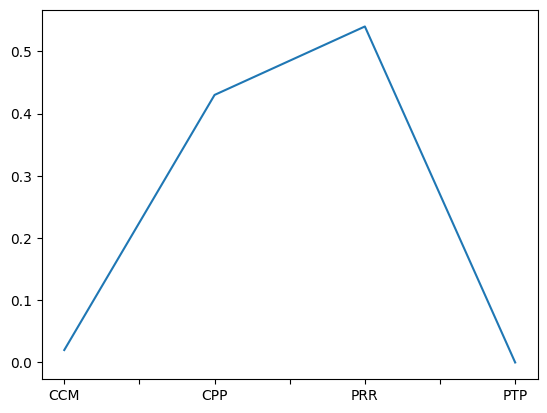

In [95]:
# ['sNumeroTramite', 'sSigla']
df_3_f = df_3.groupby(by=['sSigla']).agg({ 'sNumeroTramite': [np.ma.count] }).droplevel(level=0, axis=1)
df_3_f['count'] = np.round(df_3_f['count'] / len(df_3) , 2)
df_3_f.plot(legend=False, xlabel='')

### 3.4 Trámites de PRR, CCM, CPP y PTP con estato de trámite `APROBADO` en etapa que actualiza el estado a `APROBADO` con estado `INICIADO` ...

In [97]:
QUERY_INF_4 = '''
                     SELECT
                        t.sNumeroTramite,
                        tt.sSigla,
                        e.sDescripcion
                     FROM SimTramite t
                     JOIN SimTramiteInm ti ON t.sNumeroTramite = ti.sNumeroTramite
                     JOIN SimTipoTramite tt ON t.nIdTipoTramite = tt.nIdTipoTramite
                     JOIN SimEtapa e ON ti.nIdEtapaActual = e.nIdEtapa
                     WHERE
                        t.bCancelado = 0
                        AND ti.sEstadoActual = 'A'
                        AND t.nIdTipoTramite IN (57, 58, 113, 126)-- 57 ↔ PRR; 58 ↔ CCM; 113 ↔ CPP; 126 ↔ PTP
                        AND YEAR(t.dFechaHora) >= (
                                                      SELECT tmp.nAño
                                                      FROM (
                                                         VALUES
                                                            (2021, 57), -- >=2021  = 22 ↔ CONFORMIDAD SUB-DIREC.INMGRA. 
                                                            (2022, 58), -- >=2022 = 17 ↔ ENTREGA DE CARNET EXTRANJERIA
                                                            (2021, 113), -- >=2021 = 63 ↔ ENTREGA DE CARNÉ P.T.P.
                                                            (2023, 126) -- >=2023 = 80 ↔ ENTREGA DE CARNÉ C.P.P.
                                                      ) tmp([nAño], [nIdTipoTramite])
                                                      WHERE
                                                         tmp.nIdTipoTramite = t.nIdTipoTramite
                        )
                        AND EXISTS ( -- Etapas que aprueban el trámite ...
                                       SELECT 1
                                       FROM (
                                          SELECT 
                                             et.*,
                                             [#] = ROW_NUMBER() OVER (ORDER BY et.nIdEtapaTramite DESC)
                                          FROM SimEtapaTramiteInm et
                                          WHERE
                                             et.sNumeroTramite = t.sNumeroTramite 
                                       ) et2
                                       WHERE 
                                          et2.[#] = 1
                                          AND et2.bActivo = 1
                                          AND et2.sEstado = 'I'
                                          AND et2.nIdEtapa = (
                                                               SELECT tmp.nIdEtapa
                                                               FROM (
                                                                  VALUES
                                                                     (57, 22), -- 57  = 22 ↔ CONFORMIDAD SUB-DIREC.INMGRA. 
                                                                     (58, 17), -- 58  = 17 ↔ ENTREGA DE CARNET EXTRANJERIA
                                                                     (113, 63), -- 113 = 63 ↔ ENTREGA DE CARNÉ P.T.P.
                                                                     (126, 80) -- 126 = 80 ↔ ENTREGA DE CARNÉ C.P.P.
                                                               ) tmp([nIdTipoTramite], [nIdEtapa])
                                                               WHERE
                                                                  tmp.nIdTipoTramite = t.nIdTipoTramite
                                                               )
                                          )

'''

df_4 = get_query_sql(QUERY_INF_4)

<Axes: >

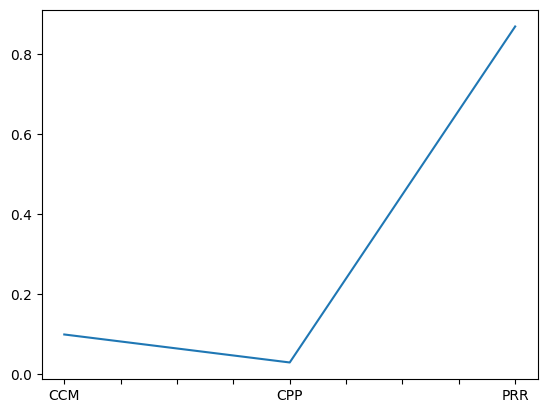

In [98]:
df_4_f = df_4.groupby(by=['sSigla']).agg({ 'sNumeroTramite': [np.ma.count] }).droplevel(level=0, axis=1)
df_4_f['count'] = np.round(df_4_f['count'] / len(df_4) , 2)
df_4_f.plot(legend=False, xlabel='')

### 3.5 Trámites de inmigración con estado de trámite `APROBADOS` en etapa `ASOCIACIÓN BENEFICIARIO` ...

In [99]:
QUERY_INF_5 = '''
                  SELECT
                     t.sNumeroTramite,
                     tt.sSigla
                  FROM SimTramite t
                  JOIN SimTramiteInm ti ON t.sNumeroTramite = ti.sNumeroTramite
                  JOIN SimTipoTramite tt ON t.nIdTipoTramite = tt.nIdTipoTramite
                  WHERE
                     t.bCancelado = 0
                     AND t.bCulminado = 1
                     AND ti.sEstadoActual = 'A'
                     AND t.nIdTipoTramite IN (57, 58, 113, 126)-- 57 ↔ PRR; 58 ↔ CCM; 113 ↔ CPP; 126 ↔ PTP
                     AND t.dFechaHora >= '2016-01-01 00:00:00.000'
                     AND (
                              SELECT COUNT(1)
                                 FROM (
                                    SELECT 
                                       et.nIdEtapa,
                                       [#] = COUNT(1) OVER (PARTITION BY et.sNumeroTramite)
                                    FROM SimEtapaTramiteInm et
                                    WHERE
                                       et.sNumeroTramite = t.sNumeroTramite
                                       AND et.bActivo = 1

                                 ) et2
                                 WHERE
                                    et2.[#] = 2
                                    AND et2.nIdEtapa IN (11, 12) -- 12 | ASOCIACION BENEFICIARIO; 11 | RECEPCIÓN DINM
                              ) = 2
'''

df_5 = get_query_sql(QUERY_INF_5)

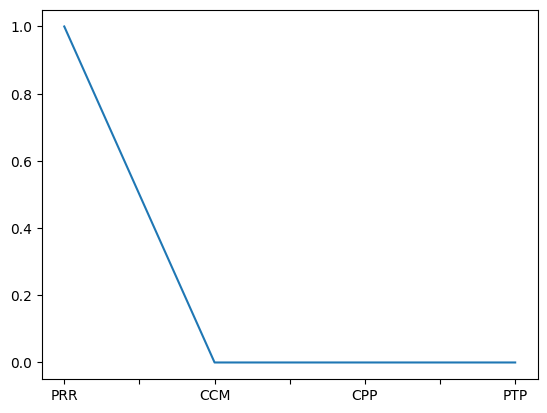

In [121]:
df_5_f = df_5.groupby(by=['sSigla']).agg({ 'sNumeroTramite': [np.ma.count] }).droplevel(level=0, axis=1)
df_5_f['count'] = np.round(df_5_f['count'] / len(df_5) , 2)
df_5_1 = pd.DataFrame(data={ 'count': [0, 0, 0] }, index=['CCM', 'CPP', 'PTP'])
df_5_f_p = pd.concat([df_5_f, df_5_1], axis=0).plot(legend=False, xlabel='')

### 3.6 Trámites de inmigración con estado de trámite `APROBADO` y registro de etapas con estado `INICIADO` ...

In [127]:
QUERY_INF_6 = """

                  SELECT
                     t.sNumeroTramite,
                     tt.sSigla,
                     et.[nCantEtapas(I)]
                  FROM SimTramite t
                  JOIN SimTramiteInm ti ON t.sNumeroTramite = ti.sNumeroTramite
                  JOIN SimPersona p ON t.uIdPersona = p.uIdPersona
                  JOIN SimTipoTramite tt ON t.nIdTipoTramite = tt.nIdTipoTramite
                  JOIN SimEtapa e ON ti.nIdEtapaActual = e.nIdEtapa
                  JOIN SimDependencia d ON t.sIdDependencia = d.sIdDependencia
                  JOIN (

                     SELECT f.*
                     FROM (
                        SELECT 
                           eti.sNumeroTramite,

                           -- Aux
                           [#] = ROW_NUMBER() OVER (PARTITION BY eti.sNumeroTramite ORDER BY eti.nIdEtapaTramite DESC),
                           [nCantEtapas(I)] = COUNT(1) OVER (PARTITION BY eti.sNumeroTramite)
                        FROM SimEtapaTramiteInm eti
                        WHERE
                           eti.sEstado = 'I'
                           AND eti.bActivo = 1
                     ) f
                     WHERE
                        f.[#] = 1
                        AND f.[nCantEtapas(I)] >= 1

                  ) et ON et.sNumeroTramite = t.sNumeroTramite
                  WHERE
                     t.bCancelado = 0
                     AND t.bCulminado = 1
                     AND t.dFechaHora >= '2016-01-01 00:00:00.000'
                     AND t.nIdTipoTramite IN (57, 58, 113, 126)-- 57: PRR; 58: CCM; 113: CPP; 126: PTP
                     AND ti.sEstadoActual = 'A'

"""

df_6 = get_query_sql(QUERY_INF_6)

<Axes: >

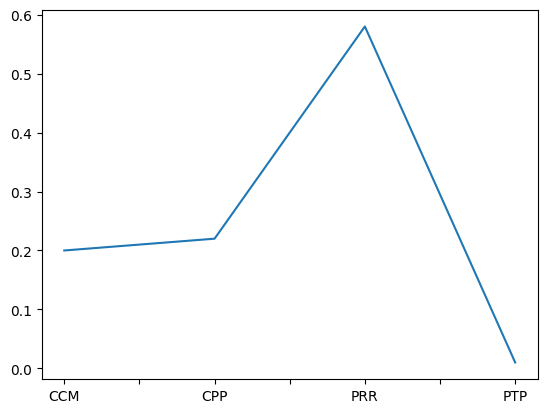

In [128]:
df_6_f = df_6.groupby(by=['sSigla']).agg({ 'sNumeroTramite': [np.ma.count] }).droplevel(level=0, axis=1)
df_6_f['count'] = np.round(df_6_f['count'] / len(df_6) , 2)
df_6_f.plot(legend=False, xlabel='')

### 3.7 Etapa actual de trámites de inmigración en `SIM.dbo.SimTramiteInm`, diferente a ultima etapa registrada en `SIM.dbo.SimEtapaTramiteInm` ...

In [7]:
SQL_INF_7 = """

                  SELECT -- Etapas distitas
                     t.sNumeroTramite,
                     tt.sSigla, 
                     ti.nIdEtapaActual,
                     let.[nIdEtapa(Ult)]
                  FROM SimTramite t
                  JOIN SimTramiteInm ti ON t.sNumeroTramite = ti.sNumeroTramite
                  JOIN SimTipoTramite tt ON t.nIdTipoTramite = tt.nIdTipoTramite
                  JOIN (

                     SELECT 
                        f.*
                     FROM (
                        SELECT 
                           eti.sNumeroTramite,

                           -- Aux
                           [#] = ROW_NUMBER() OVER (
                                                PARTITION BY eti.sNumeroTramite 
                                                ORDER BY eti.nIdEtapaTramite ASC
                                             ),
                           [nIdEtapa(Ult)] = LAST_VALUE(eti.nIdEtapa) OVER (
                                                                        PARTITION BY eti.sNumeroTramite 
                                                                        ORDER BY eti.nIdEtapaTramite ASC
                                                                        ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                                                                     ),
                           [sEstado(Ult)] = LAST_VALUE(eti.sEstado) OVER (
                                                                        PARTITION BY eti.sNumeroTramite 
                                                                        ORDER BY eti.nIdEtapaTramite ASC
                                                                        ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                                                                  )
                        FROM SimEtapaTramiteInm eti
                        WHERE
                           eti.bActivo = 1
                     ) f
                     WHERE
                        f.[#] = 1

                  ) let ON let.sNumeroTramite = t.sNumeroTramite
                  WHERE
                     t.bCancelado = 0
                     AND t.dFechaHora >= '2016-01-01 00:00:00.000'
                     AND t.nIdTipoTramite IN (57, 58, 113, 126)-- 57: PRR; 58: CCM; 113: CPP; 126: PTP
                     AND ti.nIdEtapaActual != let.[nIdEtapa(Ult)]
                  UNION ALL
                  SELECT -- Etapas iguales
                     TOP 50000
                     t.sNumeroTramite,
                     tt.sSigla, 
                     ti.nIdEtapaActual,
                     let.[nIdEtapa(Ult)]
                  FROM SimTramite t
                  JOIN SimTramiteInm ti ON t.sNumeroTramite = ti.sNumeroTramite
                  JOIN SimTipoTramite tt ON t.nIdTipoTramite = tt.nIdTipoTramite
                  JOIN (

                     SELECT 
                        f.*
                     FROM (
                        SELECT 
                           eti.sNumeroTramite,

                           -- Aux
                           [#] = ROW_NUMBER() OVER (
                                                PARTITION BY eti.sNumeroTramite 
                                                ORDER BY eti.nIdEtapaTramite ASC
                                             ),
                           [nIdEtapa(Ult)] = LAST_VALUE(eti.nIdEtapa) OVER (
                                                                        PARTITION BY eti.sNumeroTramite 
                                                                        ORDER BY eti.nIdEtapaTramite ASC
                                                                        ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                                                                     ),
                           [sEstado(Ult)] = LAST_VALUE(eti.sEstado) OVER (
                                                                        PARTITION BY eti.sNumeroTramite 
                                                                        ORDER BY eti.nIdEtapaTramite ASC
                                                                        ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                                                                  )
                        FROM SimEtapaTramiteInm eti
                        WHERE
                           eti.bActivo = 1
                     ) f
                     WHERE
                        f.[#] = 1

                  ) let ON let.sNumeroTramite = t.sNumeroTramite
                  WHERE
                     t.bCancelado = 0
                     AND t.dFechaHora >= '2016-01-01 00:00:00.000'
                     AND t.nIdTipoTramite IN (57, 58, 113, 126)-- 57: PRR; 58: CCM; 113: CPP; 126: PTP
                     AND ti.nIdEtapaActual = let.[nIdEtapa(Ult)]

"""

df_7 = get_query_sql(SQL_INF_7)

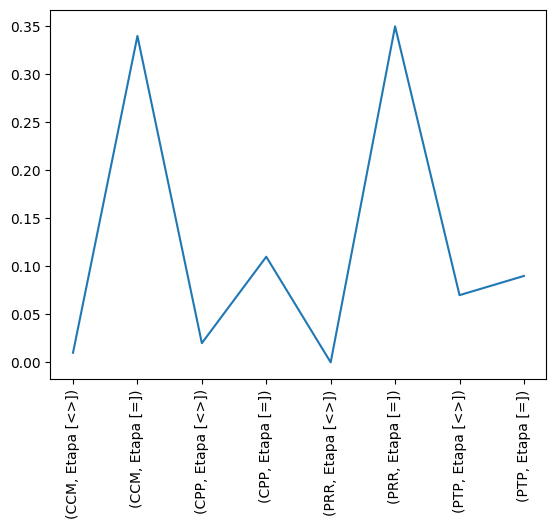

In [28]:
# ['sNumeroTramite', 'sSigla', 'nIdEtapaActual', 'nIdEtapa(Ult)']

def get_group_et(serie):
   result = 'Etapa [<>]'
   if (serie['nIdEtapaActual'] == serie['nIdEtapa(Ult)']):
      result = 'Etapa [=]'
   return result

df_7['sGrupo'] = df_7.apply(get_group_et, axis=1)

df_7_f = df_7.groupby(by=['sSigla', 'sGrupo']).agg({ 'sNumeroTramite': [np.ma.count] }).droplevel(level=0, axis=1)
df_7_f['count'] = np.round(df_7_f['count'] / len(df_7) , 2)
df_7_f_p = df_7_f.plot(legend=False, xlabel='')

for l in df_7_f_p.get_xticklabels():
   l.set_rotation(90)



### 3.8 Datos personales registrados en `SIM.dbo.SimTramiteInm` distintos a datos personales asociados al trámite ...

In [29]:
SQL_INF_8 = """

               SELECT
                  f.nGradoSimilitud,
                  COUNT(1)
               FROM (

                  SELECT 

                     p.sNumeroTramite,
                     [nGradoSimilitud] = (
                              CAST(
                                 ROUND(
                                    (
                                       (DIFFERENCE(pe.sNombre, p.sNombre) + DIFFERENCE(pe.sPaterno, p.sPaterno) + DIFFERENCE(pe.sMaterno, p.sMaterno)) / 3
                                    ),
                                    0
                                 ) AS TINYINT
                              )

                     )

                  FROM SimTramitePas p
                  JOIN SimTramite t ON p.sNumeroTramite = t.sNumeroTramite
                  JOIN SimPersona pe ON t.uIdPersona = pe.uIdPersona
                  WHERE
                     t.bCancelado = 0
                     AND pe.bActivo = 1
                     AND t.nIdTipoTramite = 90 -- 90 ↔ Expedición de Pasaporte Electrónico

               ) f
               GROUP BY
                  f.nGradoSimilitud
               ORDER BY 2 DESC

"""

df_8 = get_query_sql(SQL_INF_8)

<Axes: >

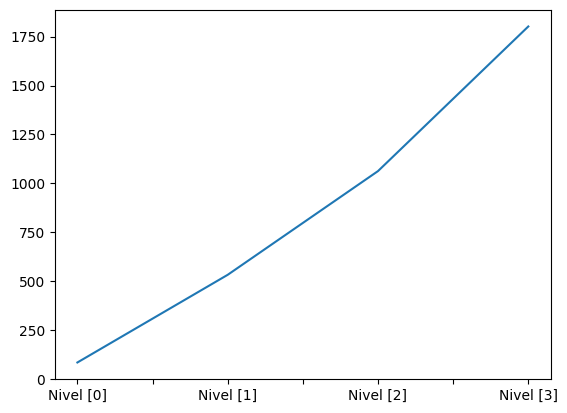

In [113]:
df_8.rename({ '': 'count' }, axis=1, inplace=True)
# df_8.set_index('nGradoSimilitud', inplace=True)
df_8_f = df_8.iloc[1:]
df_8_f.index = df_8_f.index.map(lambda i: f'Nivel [{str(i)}]')
df_8_f.sort_index().plot(legend=False, xlabel='')



### 3.9 Registros de Control Migratorio duplicados en tipo de movimiento, fecha de control, hora, minuto y segundo ...

In [114]:
SQL_INF_9 = """

               SELECT 
                  TOP 100000
                  f.*
               FROM (

                  SELECT 
                     mm.uIdPersona,
                     [sDupl(Hora)] = (
                                    CASE
                                       WHEN (-- yyyy-MM-dd HH:mm:ss
                                                COUNT(1) OVER (
                                                         PARTITION BY 
                                                               mm.uIdPersona, 
                                                               mm.sTipo, 
                                                               CONVERT(VARCHAR(19), mm.dFechaControl, 120)
                                                ) >= 2
                                       ) THEN 'HH:mn:ss'
                                       WHEN (-- yyyy-MM-dd HH:mm
                                                COUNT(1) OVER (
                                                         PARTITION BY 
                                                               mm.uIdPersona, 
                                                               mm.sTipo, 
                                                               CONVERT(VARCHAR(16), mm.dFechaControl, 120)
                                                ) >= 2
                                       ) THEN 'HH:mm'
                                       WHEN (-- yyyy-MM-dd HH
                                                COUNT(1) OVER (
                                                         PARTITION BY 
                                                               mm.uIdPersona, 
                                                               mm.sTipo, 
                                                               CONVERT(VARCHAR(13), mm.dFechaControl, 120)
                                                ) >= 2
                                       ) THEN 'HH'
                                       ELSE ''
                                    END
                     )
                     
                  FROM SimMovMigra mm
                  WHERE
                     mm.bAnulado = 0
                     AND mm.bTemporal = 0
                     AND mm.dFechaControl >= '2016-01-01 00:00:00.000'
                     AND CAST(mm.dFechaControl AS TIME) > '00:00:00' -- Excluye registros manuales

               ) f
               WHERE f.[sDupl(Hora)] != ''

"""

df_9 = get_query_sql(SQL_INF_9)

<Axes: >

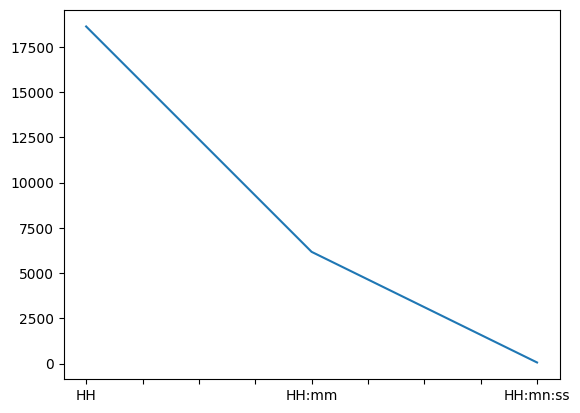

In [127]:
# ['uIdPersona', 'sDupl(Hora)']
df_9.drop_duplicates(subset=['uIdPersona'], inplace=True)
df_9_f = df_9.groupby(by=['sDupl(Hora)']).agg({ 'uIdPersona': [np.ma.count] }).droplevel(level=0, axis=1)
df_9_f.plot(legend=False, xlabel='')

### 3.10 Control Migratorios de extranjeros mayores de 18 años de edad con documento de viaje `PNA(Partida de nacimiento)` ...

In [128]:
SQL_INF_10 = """

                  SELECT 

                     TOP 100000
                     mm.sIdDocumento,
                     [nTotal] = COUNT(1)

                  FROM SimMovMigra mm
                  JOIN SimPersona p ON mm.uIdPersona = p.uIdPersona
                  WHERE
                     mm.bAnulado = 0
                     AND mm.bTemporal = 0
                     AND (mm.sIdPaisNacionalidad NOT IN ('PER', 'NNN') AND mm.sIdPaisNacionalidad IS NOT NULL)
                     -- AND mm.sIdDocumento = 'PNA' -- PNA | PARTIDA DE NACIMIENTO
                     AND DATEDIFF(YYYY, p.dFechaNacimiento, mm.dFechaControl) >= 18 -- Mayores de edad
                     AND mm.sIdDocumento IN ('PNA', 'PAS', 'CIP', 'LIB', 'CE')
                  GROUP BY
                     mm.sIdDocumento
                  ORDER BY 2 DESC

"""

df_10 = get_query_sql(SQL_INF_10)

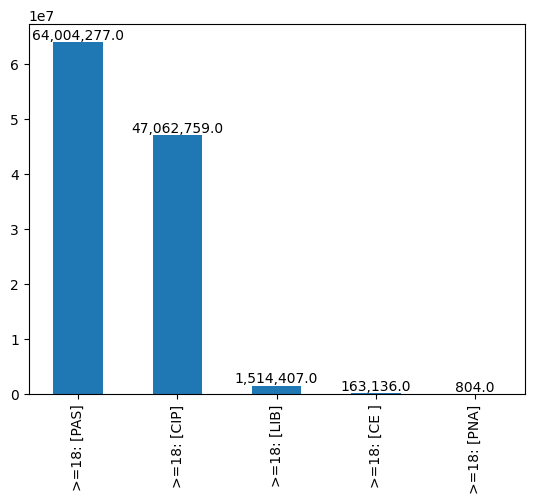

In [155]:
# ['sIdDocumento', 'nTotal']

df_10['sGrupo'] = df_10['sIdDocumento'].apply(lambda d: f'>=18: [{d}]')


df_10_f = df_10.set_index('sGrupo')
df_10_f_p = df_10_f[['nTotal']].plot.bar(legend=False, xlabel='')

for container in df_10_f_p.containers:
   df_10_f_p.bar_label(container, fmt='{:,}')
